In [1]:
import sys
import importlib
import datetime

import numpy as np
import pandas as pd
import xarray as xr
import pvlib as pv
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
sys.path.append('/home/travis/python_code/letkf_forecasting/')
import letkf_forecasting as lf

In [4]:
#for Golem
sat_14 = xr.open_dataset('/home/travis/python_code/forecasting/current_data/sat_14.nc')
sat_15 = xr.open_dataset('/home/travis/python_code/letkf_forecasting/sat_15_good.nc')
wind_15 = xr.open_dataset('/home/travis/python_code/forecasting/current_data/wind_15_crop.nc')
wind_15_smooth = xr.open_dataset('/home/travis/python_code/letkf_forecasting/wind_15_smooth.nc')
wind_15_ave = xr.open_dataset('/home/travis/python_code/letkf_forecasting/wind_15_ave.nc')
sensor_CI = pd.read_hdf('/home/travis/python_code/letkf_forecasting/sensor_CI.h5')
sensor_loc = pd.read_hdf('/home/travis/python_code/forecasting/current_data/sensor_loc.h5')

In [5]:
#This is taken from http://www.groundcontrol.com/Satellite_Look_Angle_Calculator.html
goes15_azimuth = 220.5
goes15_elevation = 44.1

time = pd.Timestamp('2014-04-15 11:00:00').tz_localize('MST')
tus = pv.location.Location(32.2, -111, 'US/Arizona', 700,'Tucson')
solar_position = tus.get_solarposition(time)
lf.parallax_shift(2000,
                     goes15_azimuth,
                     goes15_elevation,
                     solar_position['azimuth'].values*np.pi/360,
                     solar_position['elevation'].values*np.pi/360)

(array([-5781.68704891]), array([-218694.14370625]))

In [16]:
importlib.reload(lf)

tus = pv.location.Location(32.2, -111, 'US/Arizona', 700,'Tucson')
start_time = '2014-04-15 11:00:00' #11:00:00 is not a bad start
end_time = '2014-04-15 14:30:00' #Gets boring shortly after 14:00:00

min_cloud_height = 1000
max_cloud_height = 14000
number = 100
cloud_height_range = np.linspace(min_cloud_height, max_cloud_height, number)

RMSE = np.ones([12, number])*np.nan # 12 is number of images
lat_corrections = RMSE.copy()
lon_corrections = RMSE.copy()

count = 0
for cloud_height in cloud_height_range:
    temp_error, lat_correction, lon_correction, time_range = lf.test_parallax(
        sat_15, sensor_CI, sensor_loc, start_time, end_time,
        tus, cloud_height, goes15_azimuth, goes15_elevation)
    lat_corrections[:, count] = lat_correction
    lon_corrections[:, count] = lon_correction
    temp_error = temp_error**2
    temp_error = np.sqrt(temp_error.mean(axis=1))
    RMSE[:, count] = temp_error
    count += 1

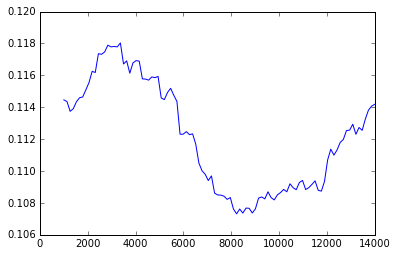

In [17]:
plt.plot(cloud_height_range, RMSE.mean(axis=0))
min_height_index = RMSE.mean(axis=0).argmin()
min_height = cloud_height_range[min_height_index]

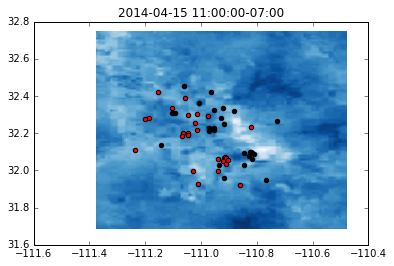

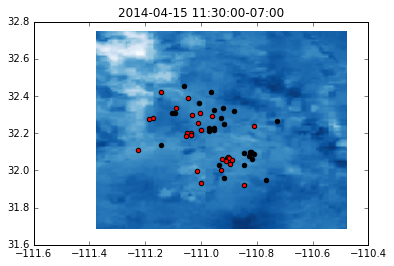

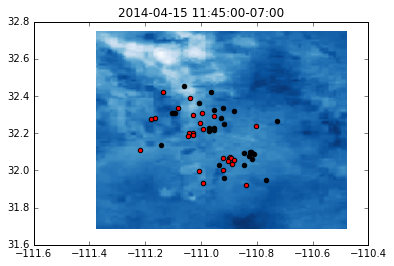

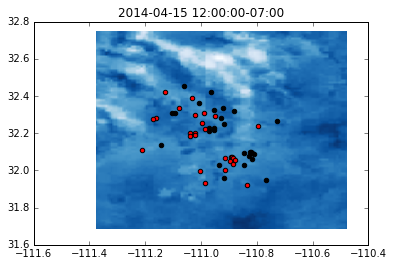

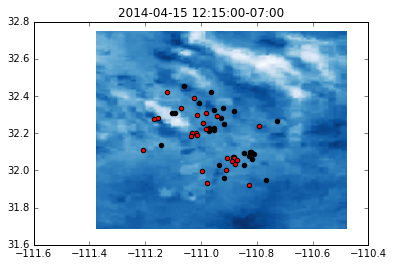

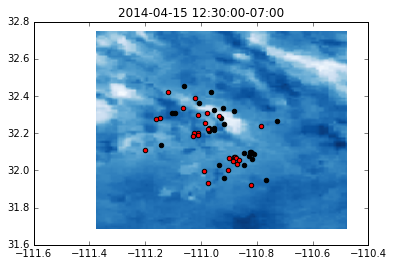

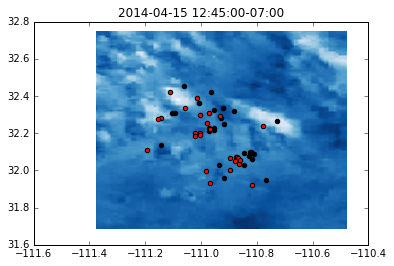

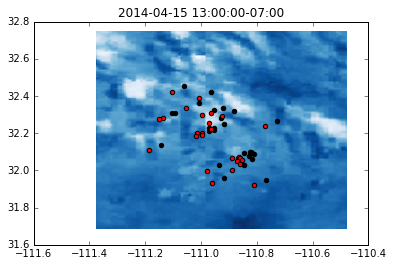

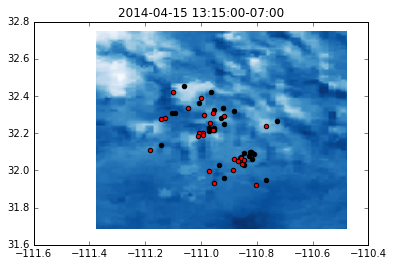

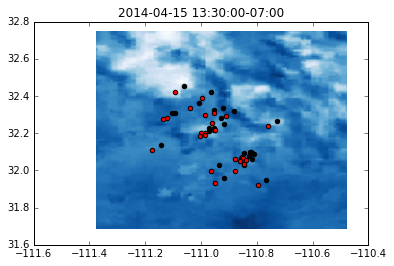

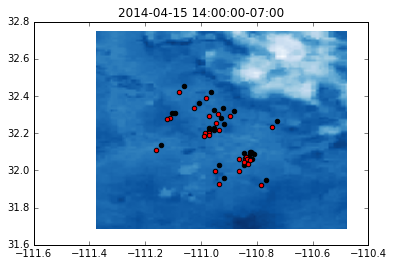

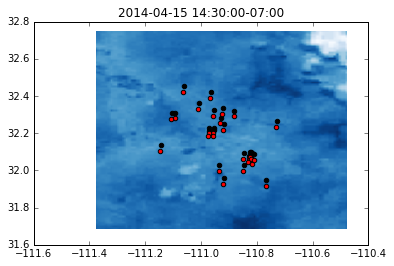

In [18]:
crop = slice(200, 600)
these_lat_corrections = lat_corrections[:, min_height_index]
these_lon_corrections = lon_corrections[:, min_height_index]
lat = sat_15['lat'].values[crop, crop]
lon = sat_15['long'].values[crop, crop]
for time_index in range(time_range.size):
    time = time_range[time_index]
    
    plt.figure()
    plt.title(pd.Timestamp(time).tz_localize('UTC').tz_convert('MST'))
    plt.pcolormesh(lon, lat,
                   sat_15['pixel'].sel(time=time).values[crop, crop],
                   cmap='Blues_r')
    plt.scatter(sensor_loc['lon'], sensor_loc['lat'], c='k')
    plt.scatter(sensor_loc['lon'] + lon_corrections[time_index, min_height_index],
                sensor_loc['lat'] + lat_corrections[time_index, min_height_index],
                c='r')